# 📷 Classification d'images Cifar-10

Le jeu de données `CIFAR-10` se compose de `60000` images couleur `32x32` dans `10` classes, avec `6000` images par classe. Il y a '50000' images d'entraînement et '10000' images de test.

# 🔬 Définition du problème :

Etant donné une image, peut-on prédire la bonne classe de cette image ?

Les images sont très petites (`32x32`) et en les visualisant vous remarquerez à quel point il est difficile de les distinguer même pour un humain.

Dans ce cahier, nous allons construire un modèle CNN capable de classer les images de divers objets. Nous avons la classe '10' d'images :
1. Avion
2. Automobile
3. Oiseau
4. Chat
5. Cerf
6. Chien
7. Grenouille
8. Cheval
9. Navire
10. Camion

# 🎯 Évaluation :

Nous avons '10' classes, donc si nous choisissons une image et que nous devinons sa classe au hasard, nous avons '1/10' de probabilité d'être vrai.

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.datasets import cifar10
from tensorflow.keras.utils import to_categorical

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D, Flatten, Dropout, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report, confusion_matrix

# 📥 Charger les données

In [3]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

In [4]:
print(f"X_train shape: {X_train.shape}")
print(f"y_train shape: {y_train.shape}")
print(f"X_test shape: {X_test.shape}")
print(f"y_test shape: {y_test.shape}")

X_train shape: (50000, 32, 32, 3)
y_train shape: (50000, 1)
X_test shape: (10000, 32, 32, 3)
y_test shape: (10000, 1)


# 🖼 Visualisation des données

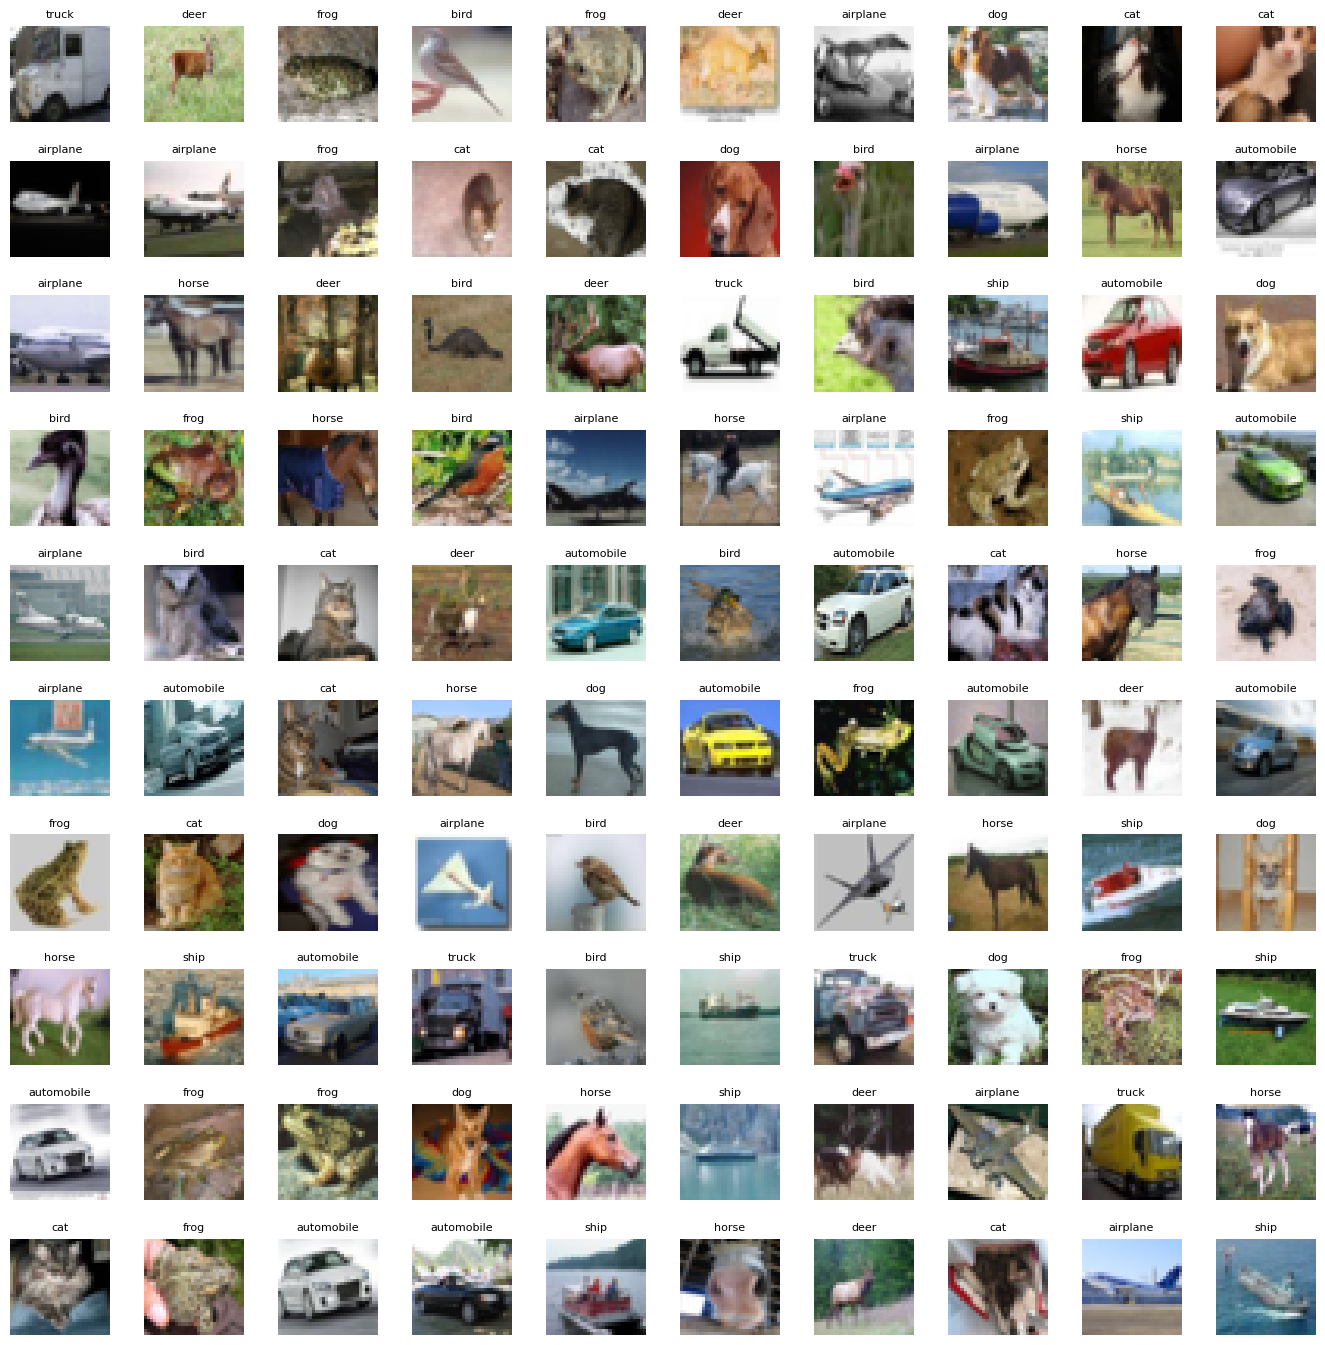

In [5]:
# Définir les étiquettes du jeu de données
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Voyons plus d'images dans un format de grille
# Définir les dimensions de la grille de tracé
W_grid = 10
L_grid = 10

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot renvoie l'objet figure et l'objet axes
# nous pouvons utiliser l'objet axes pour tracer des figures spécifiques à divers endroits

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() # aplatir(flatten) la matrice 15x15 en un tableau 225

n_train = len(X_train) # obtenir la longueur du jeu de données de train

# Sélectionnez un nombre aléatoire de 0 à n_train
for i in np.arange(0, W_grid * L_grid): # créer des variables à espaces réguliers

   # Sélectionnez un nombre aléatoire
    index = np.random.randint(0, n_train)
    # lire et afficher une image avec l'index sélectionné
    axes[i].imshow(X_train[index,1:])
    label_index = int(y_train[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [ ]:
classes_name = ['Airplane', 'Automobile', 'Bird', 'Cat', 'Deer', 'Dog', 'Frog', 'Horse', 'Ship', 'Truck']

classes, counts = np.unique(y_train, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Répartition des classes dans ensemble entraînement')

In [ ]:
classes, counts = np.unique(y_test, return_counts=True)
plt.barh(classes_name, counts)
plt.title('Class distribution in testing set')

La classe est équitablement répartie

# 🔄 Prétraitement des données

In [8]:
# Mettre à l'échelle les données
X_train = X_train / 255.0
X_test = X_test / 255.0

# Transformer la variable cible en un encodage à chaud
y_cat_train = to_categorical(y_train, 10)
y_cat_test = to_categorical(y_test, 10)

In [9]:
y_cat_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 0., 0., ..., 0., 0., 1.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [0., 1., 0., ..., 0., 0., 0.],
       [0., 1., 0., ..., 0., 0., 0.]], dtype=float32)

# 🤖 Modélisation

In [10]:
model = Sequential()

# Couche convolutive
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=32, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
# Couche de regroupement
model.add(MaxPool2D(pool_size=(2, 2)))
# Couches abandonnées
model.add(Dropout(0.25))

model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=64, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(Conv2D(filters=128, kernel_size=(3, 3), input_shape=(32, 32, 3), activation='relu', padding='same'))
model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))
model.add(Dropout(0.25))

model.add(Flatten())
# model.add(Dropout(0.2))
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='softmax'))

METRICS = [
    'accuracy',
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall')
]
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=METRICS)

In [11]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 32, 32, 32)        896       
                                                                 
 batch_normalization (BatchN  (None, 32, 32, 32)       128       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 32, 32, 32)        9248      
                                                                 
 batch_normalization_1 (Batc  (None, 32, 32, 32)       128       
 hNormalization)                                                 
                                                                 
 max_pooling2d (MaxPooling2D  (None, 16, 16, 32)       0         
 )                                                               
                                                        

## Arrêt anticipé

In [12]:
early_stop = EarlyStopping(monitor='val_loss', patience=2)

## Augmentations de données

In [13]:
batch_size = 32
data_generator = ImageDataGenerator(width_shift_range=0.1, height_shift_range=0.1, horizontal_flip=True)
train_generator = data_generator.flow(X_train, y_cat_train, batch_size)
steps_per_epoch = X_train.shape[0] // batch_size

In [14]:
r = model.fit(train_generator, 
              epochs=50,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
#               batch_size=batch_size,
             )

Epoch 1/50
1562/1562 [==============================] - 336s 213ms/step - loss: 1.6325 - accuracy: 0.4048 - precision: 0.6159 - recall: 0.1877 - val_loss: 1.3218 - val_accuracy: 0.5183 - val_precision: 0.7063 - val_recall: 0.3323
Epoch 2/50
1562/1562 [==============================] - 320s 205ms/step - loss: 1.2390 - accuracy: 0.5576 - precision: 0.7259 - recall: 0.3863 - val_loss: 0.9738 - val_accuracy: 0.6613 - val_precision: 0.7835 - val_recall: 0.5306
Epoch 3/50
1562/1562 [==============================] - 303s 194ms/step - loss: 1.0530 - accuracy: 0.6309 - precision: 0.7693 - recall: 0.4935 - val_loss: 0.8959 - val_accuracy: 0.6894 - val_precision: 0.7839 - val_recall: 0.5917
Epoch 4/50
1562/1562 [==============================] - 311s 199ms/step - loss: 0.9388 - accuracy: 0.6752 - precision: 0.7931 - recall: 0.5597 - val_loss: 0.9189 - val_accuracy: 0.6866 - val_precision: 0.7995 - val_recall: 0.5836
Epoch 5/50
1562/1562 [==============================] - 291s 186ms/step - loss: 

# 📊 Model Evaluation

In [ ]:
plt.figure(figsize=(12, 16))

plt.subplot(4, 2, 1)
plt.plot(r.history['loss'], label='Loss')
plt.plot(r.history['val_loss'], label='val_Loss')
plt.title('Loss Function Evolution')
plt.legend()

plt.subplot(4, 2, 2)
plt.plot(r.history['accuracy'], label='accuracy')
plt.plot(r.history['val_accuracy'], label='val_accuracy')
plt.title('Accuracy Function Evolution')
plt.legend()

plt.subplot(4, 2, 3)
plt.plot(r.history['precision'], label='precision')
plt.plot(r.history['val_precision'], label='val_precision')
plt.title('Precision Function Evolution')
plt.legend()

plt.subplot(4, 2, 4)
plt.plot(r.history['recall'], label='recall')
plt.plot(r.history['val_recall'], label='val_recall')
plt.title('Recall Function Evolution')
plt.legend()

In [ ]:
evaluation = model.evaluate(X_test, y_cat_test)
print(f'Test Accuracy : {evaluation[1] * 100:.2f}%')

In [ ]:
y_pred = model.predict(X_test)
y_pred = np.argmax(y_pred, axis=1)
cm = confusion_matrix(y_test, y_pred)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,
                              display_labels=labels)


# REMARQUE : remplissez toutes les variables ici avec les valeurs par défaut de plot_confusion_matrix
fig, ax = plt.subplots(figsize=(10, 10))
disp = disp.plot(xticks_rotation='vertical', ax=ax,cmap='summer')

plt.show()

In [19]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.90      0.89      0.89      1000
           1       0.94      0.96      0.95      1000
           2       0.86      0.81      0.83      1000
           3       0.82      0.69      0.75      1000
           4       0.88      0.85      0.87      1000
           5       0.86      0.78      0.82      1000
           6       0.73      0.97      0.83      1000
           7       0.90      0.93      0.91      1000
           8       0.94      0.93      0.93      1000
           9       0.94      0.94      0.94      1000

    accuracy                           0.87     10000
   macro avg       0.88      0.87      0.87     10000
weighted avg       0.88      0.87      0.87     10000



## Test sur une image

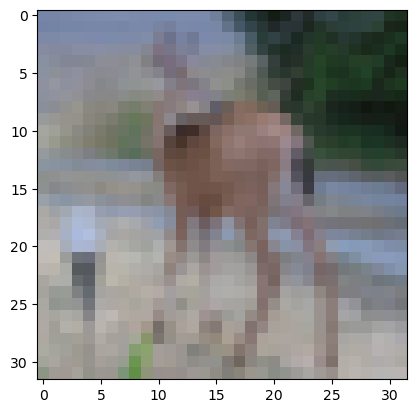

In [20]:
my_image = X_test[100]
plt.imshow(my_image)

In [21]:
# c'est un cerf
y_test[100]

array([4], dtype=uint8)

In [22]:
# correctement prédit comme un cerf
np.argmax(model.predict(my_image.reshape(1, 32, 32, 3)))

1/1 [==============================] - 0s 94ms/step


4

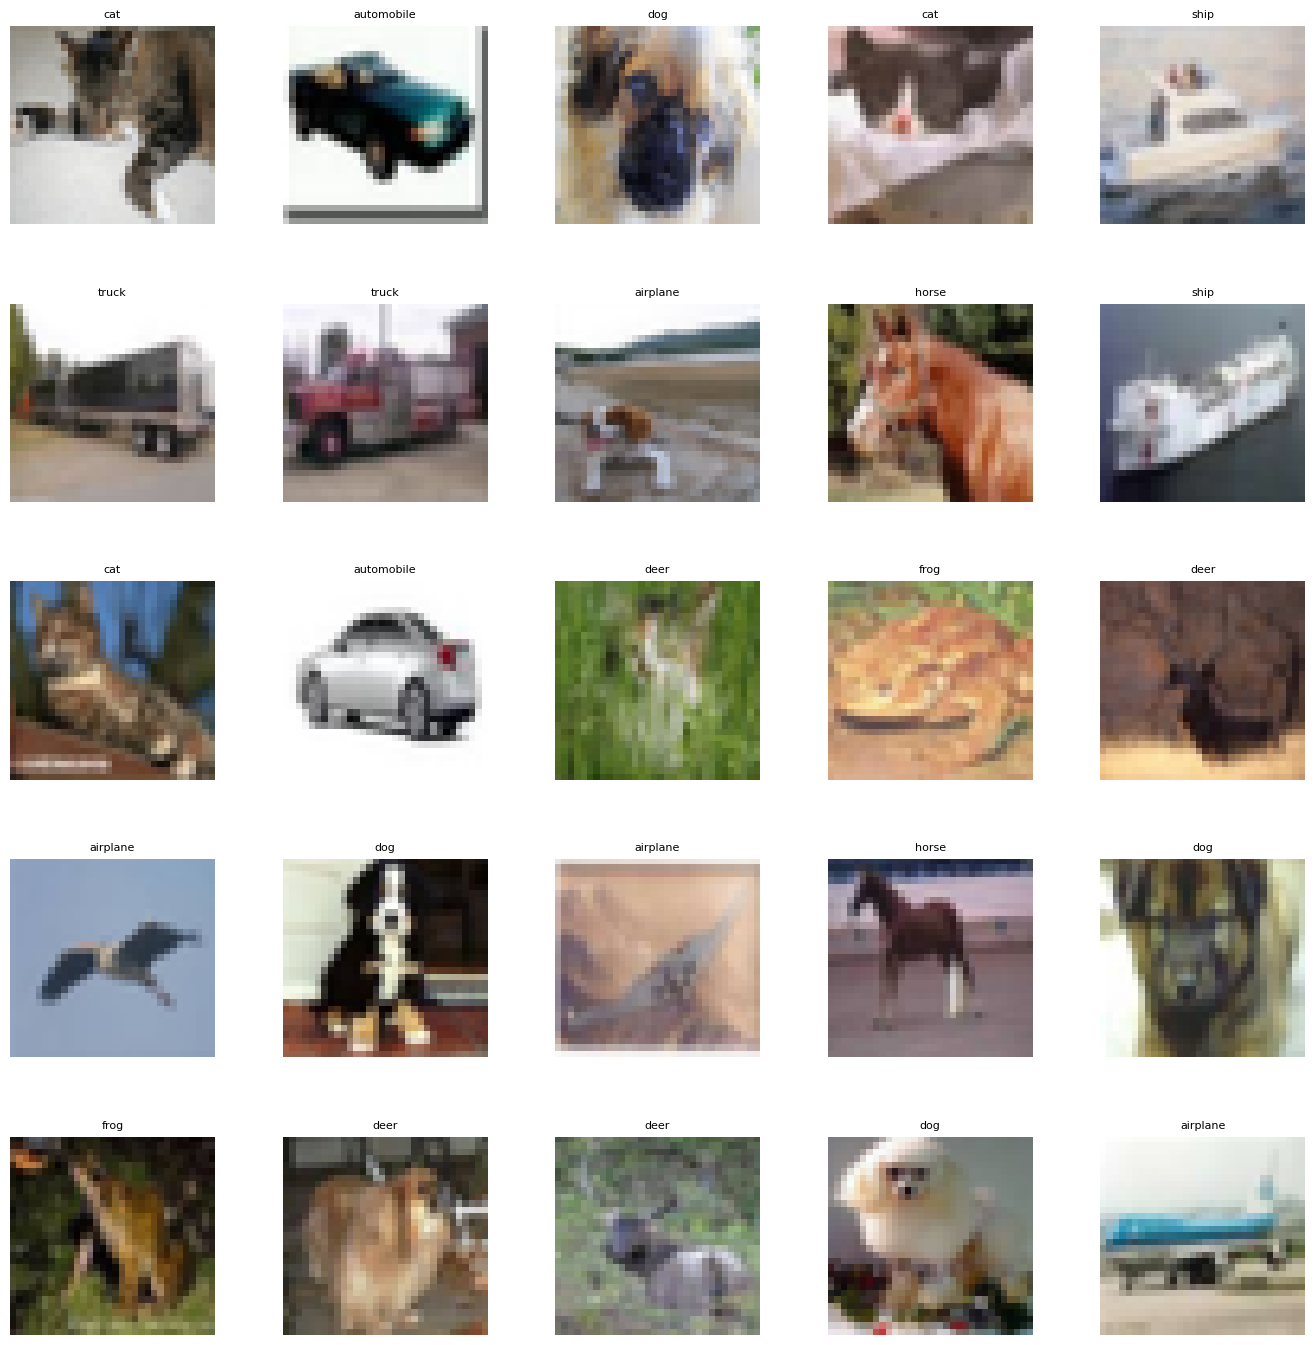

In [23]:
# Définir les étiquettes du jeu de données
labels = ['airplane', 'automobile', 'bird', 'cat', 'deer', 
          'dog', 'frog', 'horse', 'ship', 'truck']

# Voyons plus d'images dans un format de grille
# Définir les dimensions de la grille de tracé
W_grid = 5
L_grid = 5

# fig, axes = plt.subplots(L_grid, W_grid)
# subplot renvoie l'objet figure et l'objet axes
# nous pouvons utiliser l'objet axes pour tracer des figures spécifiques à divers endroits

fig, axes = plt.subplots(L_grid, W_grid, figsize = (17,17))

axes = axes.ravel() #aplatir (flaten) la matrice 15 x 15 dans le tableau 225

n_test = len(X_test) # obtenir la longueur du jeu de données de train

# Sélectionnez un nombre aléatoire de 0 à n_train
for i in np.arange(0, W_grid * L_grid): # créer des variables à espaces réguliers

    # Sélectionnez un nombre aléatoire
    index = np.random.randint(0, n_test)
# lire et afficher une image avec l'index sélectionné
    axes[i].imshow(X_test[index,1:])
    label_index = int(y_pred[index])
    axes[i].set_title(labels[label_index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

In [24]:
predictions = model.predict(X_test)

313/313 [==============================] - 14s 44ms/step


In [25]:
def plot_image(i, predictions_array, true_label, img):
    predictions_array, true_label, img = predictions_array, true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel(f"{labels[int(predicted_label)]} {100*np.max(predictions_array):2.0f}% ({labels[int(true_label)]})", 
               color=color)

def plot_value_array(i, predictions_array, true_label):
    predictions_array, true_label = predictions_array, int(true_label[i])
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

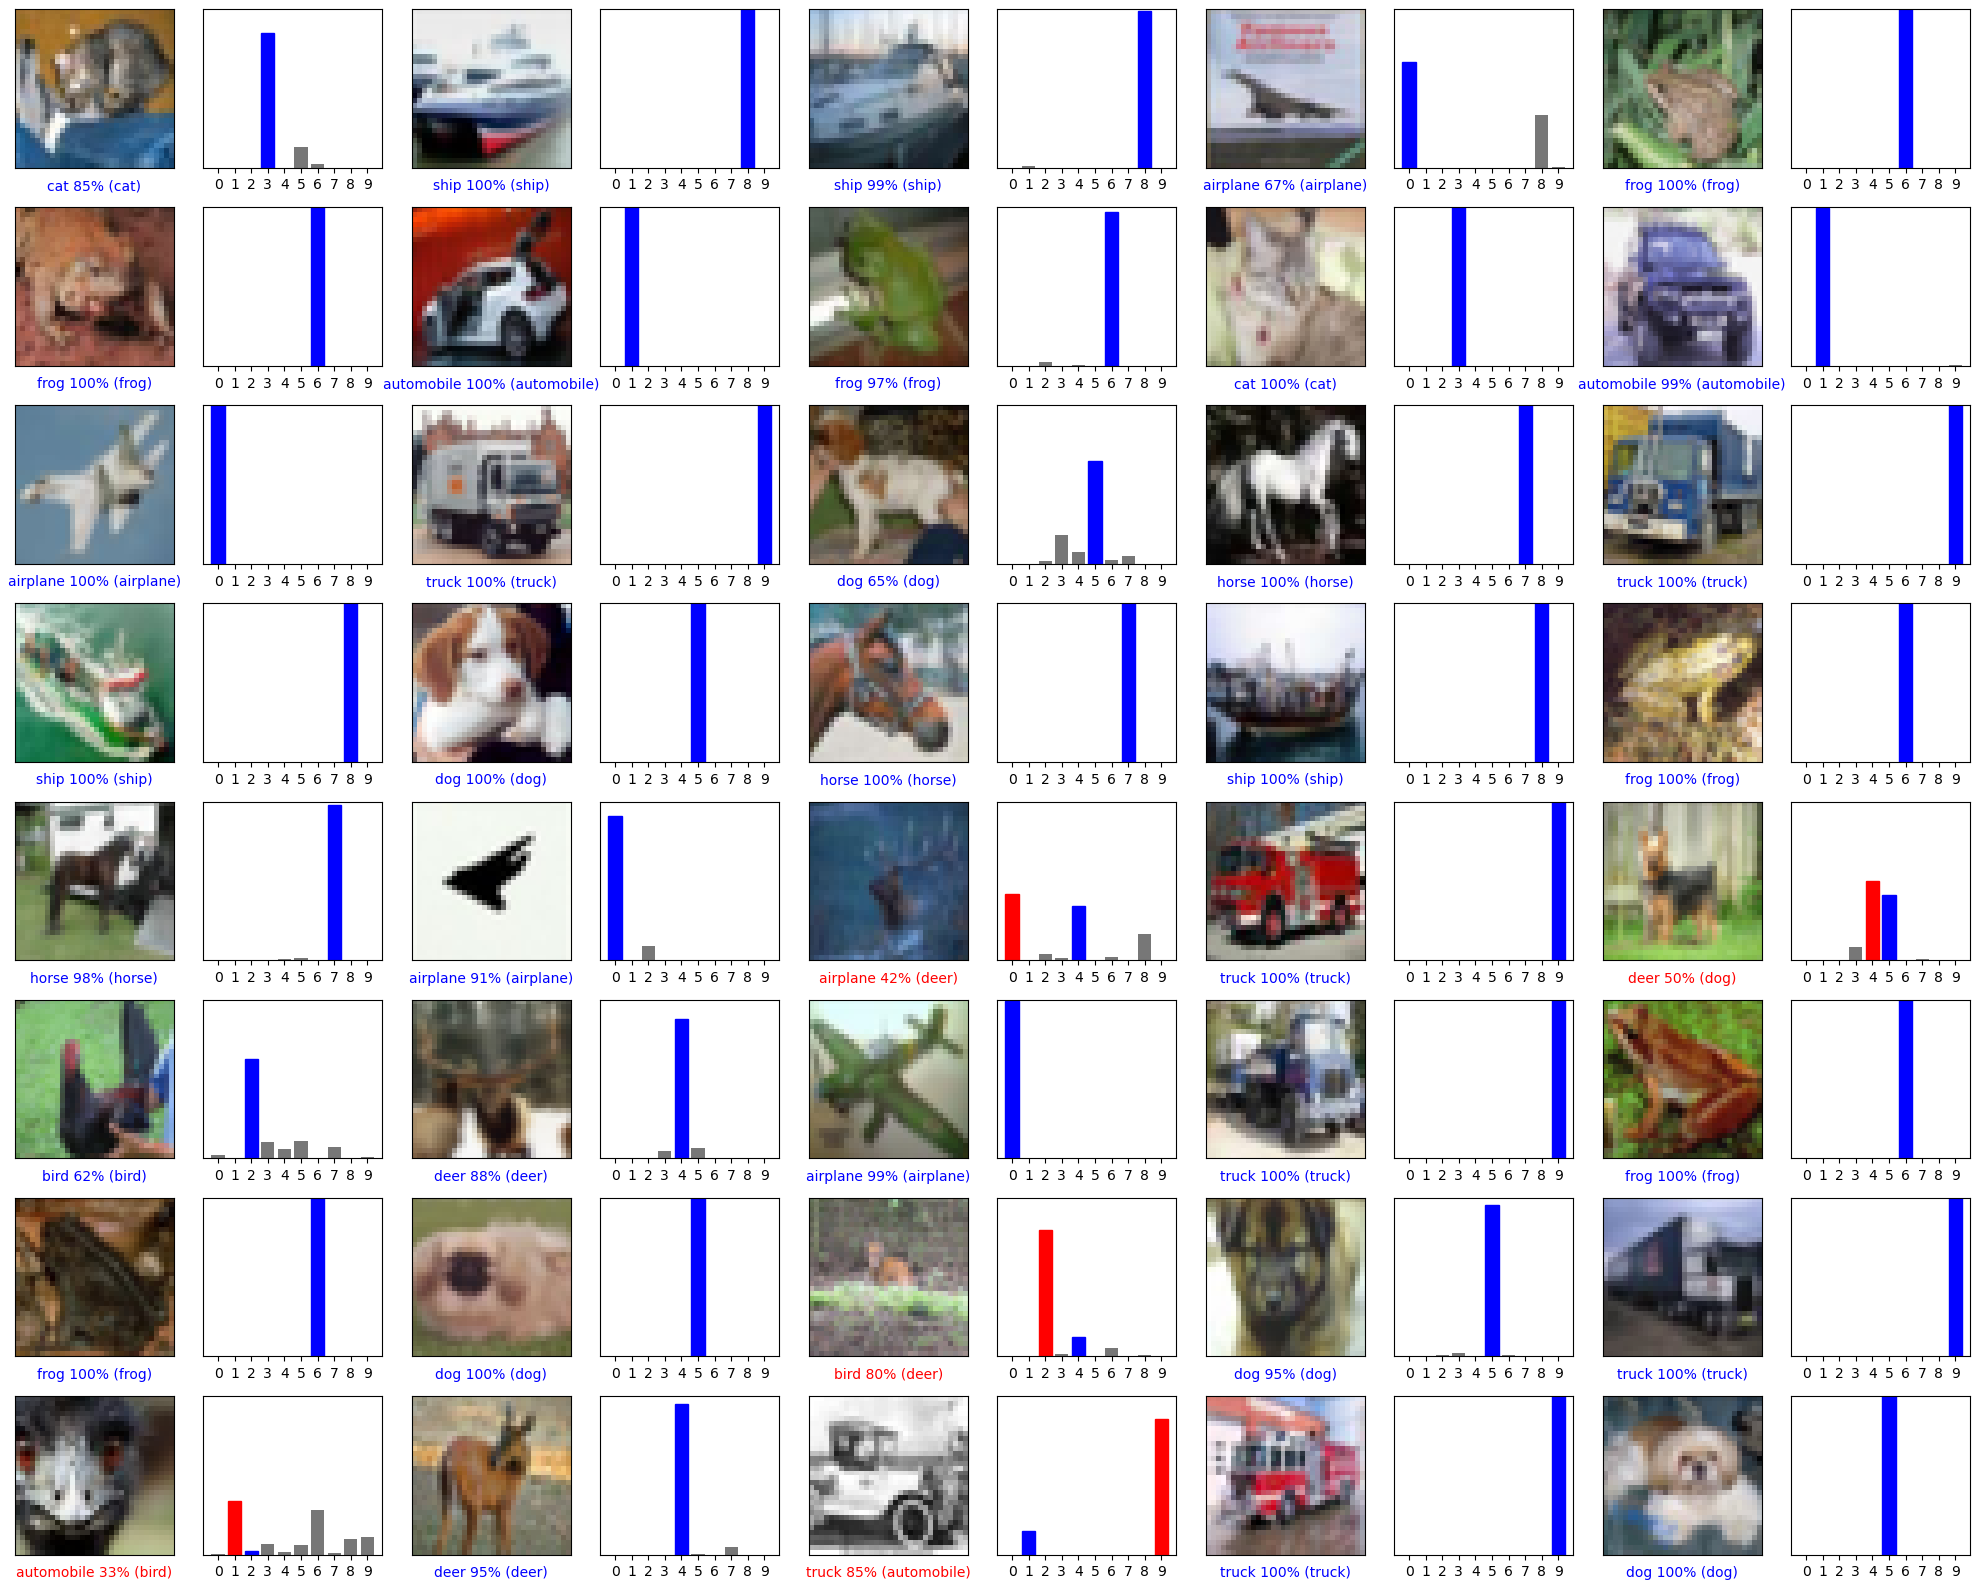

In [26]:
# Tracez les premières images de test X, leurs étiquettes prédites et les vraies étiquettes.
# Coloriez les prédictions correctes en bleu et les prédictions incorrectes en rouge.
num_rows = 8
num_cols = 5
num_images = num_rows * num_cols
plt.figure(figsize=(2 * 2 * num_cols, 2 * num_rows))
for i in range(num_images):
    plt.subplot(num_rows, 2 * num_cols, 2 * i + 1)
    plot_image(i, predictions[i], y_test, X_test)
    plt.subplot(num_rows, 2*num_cols, 2*i+2)
    plot_value_array(i, predictions[i], y_test)
plt.tight_layout()
plt.show()

# 6. Modèle DenseNet pour la classification des images

In [ ]:
from keras.applications.densenet import DenseNet121
from keras.layers import Dense
from keras.models import Sequential

model = Sequential()
base_model = DenseNet121(input_shape=(32, 32, 3), include_top=False, weights='imagenet', pooling='avg')
model.add(base_model)
model.add(Dense(10, activation='softmax'))
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

r = model.fit(train_generator, 
              epochs=100,
              steps_per_epoch=steps_per_epoch,
              validation_data=(X_test, y_cat_test), 
#               callbacks=[early_stop],
             )

Epoch 1/100
1562/1562 [==============================] - 971s 600ms/step - loss: 1.2328 - accuracy: 0.5846 - val_loss: 1.5206 - val_accuracy: 0.5542
Epoch 2/100
1562/1562 [==============================] - 978s 626ms/step - loss: 0.9910 - accuracy: 0.6640 - val_loss: 1.9545 - val_accuracy: 0.4459
Epoch 3/100
1562/1562 [==============================] - 775s 496ms/step - loss: 0.8545 - accuracy: 0.7125 - val_loss: 0.8007 - val_accuracy: 0.7263
Epoch 4/100
1562/1562 [==============================] - 782s 501ms/step - loss: 0.8262 - accuracy: 0.7243 - val_loss: 1.5768 - val_accuracy: 0.5181
Epoch 5/100
1562/1562 [==============================] - 720s 461ms/step - loss: 1.2287 - accuracy: 0.5854 - val_loss: 0.9211 - val_accuracy: 0.6848
Epoch 6/100
1562/1562 [==============================] - 752s 481ms/step - loss: 0.7967 - accuracy: 0.7271 - val_loss: 0.8229 - val_accuracy: 0.7404
Epoch 7/100
1562/1562 [==============================] - 673s 431ms/step - loss: 0.6712 - accuracy: 0.7689

# 7. Enregistrez les modèles

In [ ]:
from tensorflow.keras.models import load_model

model.save('cnn_20_epochs.h5')